In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.cloud import bigquery  # HAPUS BARIS INI
import warnings
warnings.filterwarnings('ignore')

# Setup untuk Google Colab
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# GANTI FUNGSI setup_bigquery dan load_data_from_bigquery dengan ini:

def load_data_from_csv():
    """Load data dari file CSV yang diupload"""
    from google.colab import files

    print("="*60)
    print("UPLOAD FILE CSV UNTUK ANALISIS PPh BADAN")
    print("="*60)
    print("Silakan upload file CSV Anda:")
    print("- Bisa satu file gabungan atau beberapa file terpisah")
    print("- File harus berisi data keuangan perusahaan")
    print("- Kolom yang diperlukan: laba_sebelum_pajak, nama_perusahaan, periode")
    print("\nMengupload file...")

    uploaded = files.upload()

    dataframes = {}

    # Load setiap file yang diupload
    for filename in uploaded.keys():
        print(f"\n📁 Loading {filename}...")
        try:
            df = pd.read_csv(filename)
            dataframes[filename] = df
            print(f"   ✅ Berhasil: {df.shape[0]} baris, {df.shape[1]} kolom")
            print(f"   📊 Kolom: {list(df.columns)[:5]}...")  # Tampilkan 5 kolom pertama
        except Exception as e:
            print(f"   ❌ Error: {e}")

    # Jika ada beberapa file, gunakan yang pertama sebagai main
    if len(dataframes) == 1:
        filename = list(dataframes.keys())[0]
        df_main = dataframes[filename]
        return df_main, df_main, df_main, df_main

    # Jika ada beberapa file dengan nama spesifik
    df_aruskas = dataframes.get('aruskas.csv', pd.DataFrame())
    df_asettetap = dataframes.get('asettetap.csv', pd.DataFrame())
    df_kebijakanfiskal = dataframes.get('kebijakanfiskal.csv', pd.DataFrame())
    df_transaksikeuangan = dataframes.get('transaksikeuangan.csv', pd.DataFrame())

    # Jika file transaksi kosong, gunakan file pertama
    if df_transaksikeuangan.empty:
        filename = list(dataframes.keys())[0]
        df_transaksikeuangan = dataframes[filename]

    return df_aruskas, df_asettetap, df_kebijakanfiskal, df_transaksikeuangan

In [ ]:
# GANTI fungsi process_data dengan ini:

def process_data(df_aruskas, df_asettetap, df_kebijakanfiskal, df_transaksikeuangan):
    """Proses dan gabungkan data untuk analisis pajak"""

    print("\n" + "="*60)
    print("MEMPROSES DATA")
    print("="*60)

    # Gunakan tabel transaksi keuangan sebagai base
    df_main = df_transaksikeuangan.copy()

    print(f"📊 Data shape: {df_main.shape}")
    print(f"📋 Kolom tersedia: {list(df_main.columns)}")

    # Mapping kolom yang mungkin ada (case insensitive)
    column_mapping = {
        'laba_sebelum_pajak': ['laba_sebelum_pajak', 'profit_before_tax', 'ebt', 'earning_before_tax', 'laba_kotor', 'gross_profit'],
        'laba_bersih': ['laba_bersih', 'net_income', 'laba_setelah_pajak', 'net_profit'],
        'pendapatan': ['pendapatan', 'revenue', 'penjualan', 'sales', 'omzet'],
        'nama_perusahaan': ['nama_perusahaan', 'perusahaan', 'company_name', 'company', 'nama'],
        'periode': ['periode', 'tanggal', 'date', 'tahun', 'year', 'bulan', 'month']
    }

    # Standardisasi nama kolom
    df_columns_lower = [col.lower().replace(' ', '_') for col in df_main.columns]

    for standard_name, possible_names in column_mapping.items():
        found = False
        for possible in possible_names:
            if possible.lower() in df_columns_lower:
                idx = df_columns_lower.index(possible.lower())
                actual_column = df_main.columns[idx]
                if actual_column != standard_name:
                    df_main = df_main.rename(columns={actual_column: standard_name})
                print(f"   ✅ Kolom '{actual_column}' → '{standard_name}'")
                found = True
                break

        if not found:
            print(f"   ⚠️  Kolom '{standard_name}' tidak ditemukan")

    # Buat kolom laba_kena_pajak
    if 'laba_sebelum_pajak' in df_main.columns:
        df_main['laba_kena_pajak'] = df_main['laba_sebelum_pajak']
        print("   ✅ Menggunakan kolom 'laba_sebelum_pajak'")
    elif 'laba_bersih' in df_main.columns:
        # Estimasi laba sebelum pajak dari laba bersih (asumsi tarif 25%)
        df_main['laba_kena_pajak'] = df_main['laba_bersih'] / 0.75
        print("   ℹ️  Mengestimasi laba_kena_pajak dari laba_bersih")
    elif 'pendapatan' in df_main.columns:
        # Estimasi dari pendapatan (asumsi margin 10%)
        df_main['laba_kena_pajak'] = df_main['pendapatan'] * 0.1
        print("   ℹ️  Mengestimasi laba_kena_pajak dari pendapatan")
    else:
        # Buat data dummy jika tidak ada
        print("   ⚠️  Membuat data dummy untuk laba_kena_pajak")
        df_main['laba_kena_pajak'] = np.random.uniform(100000, 10000000, len(df_main))

    # Pastikan laba_kena_pajak adalah numerik dan tidak negatif
    df_main['laba_kena_pajak'] = pd.to_numeric(df_main['laba_kena_pajak'], errors='coerce')
    df_main['laba_kena_pajak'] = df_main['laba_kena_pajak'].fillna(0).clip(lower=0)

    # Hitung beban pajak
    df_main['beban_pajak_normal'] = df_main['laba_kena_pajak'] * 0.25      # Tarif normal 25%
    df_main['beban_pajak_holiday'] = df_main['laba_kena_pajak'] * 0.05     # Tax holiday 5%

    # Hitung laba setelah pajak
    df_main['laba_setelah_pajak_normal'] = df_main['laba_kena_pajak'] - df_main['beban_pajak_normal']
    df_main['laba_setelah_pajak_holiday'] = df_main['laba_kena_pajak'] - df_main['beban_pajak_holiday']

    # Hitung penghematan pajak
    df_main['tax_savings'] = df_main['beban_pajak_normal'] - df_main['beban_pajak_holiday']

    # Buat kolom perusahaan jika tidak ada
    if 'nama_perusahaan' not in df_main.columns and 'perusahaan' not in df_main.columns:
        df_main['perusahaan'] = [f'Perusahaan_{i:03d}' for i in range(1, len(df_main)+1)]
        print("   ℹ️  Membuat kolom 'perusahaan' otomatis")
    elif 'nama_perusahaan' in df_main.columns:
        df_main['perusahaan'] = df_main['nama_perusahaan']

    # Buat kolom periode jika tidak ada
    if 'periode' not in df_main.columns:
        df_main['periode'] = pd.date_range('2023-01-01', periods=len(df_main), freq='D')
        print("   ℹ️  Membuat kolom 'periode' otomatis")
    else:
        # Konversi ke datetime jika belum
        try:
            df_main['periode'] = pd.to_datetime(df_main['periode'])
        except:
            print("   ⚠️  Tidak bisa konversi periode ke datetime")

    print(f"\n✅ Data berhasil diproses!")
    print(f"   📊 Shape final: {df_main.shape}")
    print(f"   💰 Total laba kena pajak: Rp {df_main['laba_kena_pajak'].sum():,.0f}")

    return df_main

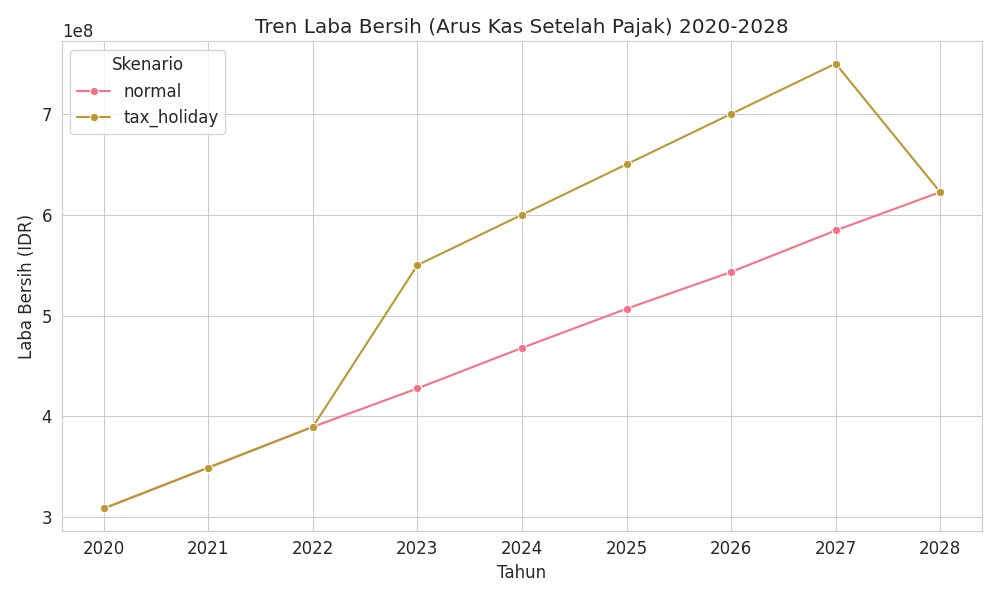

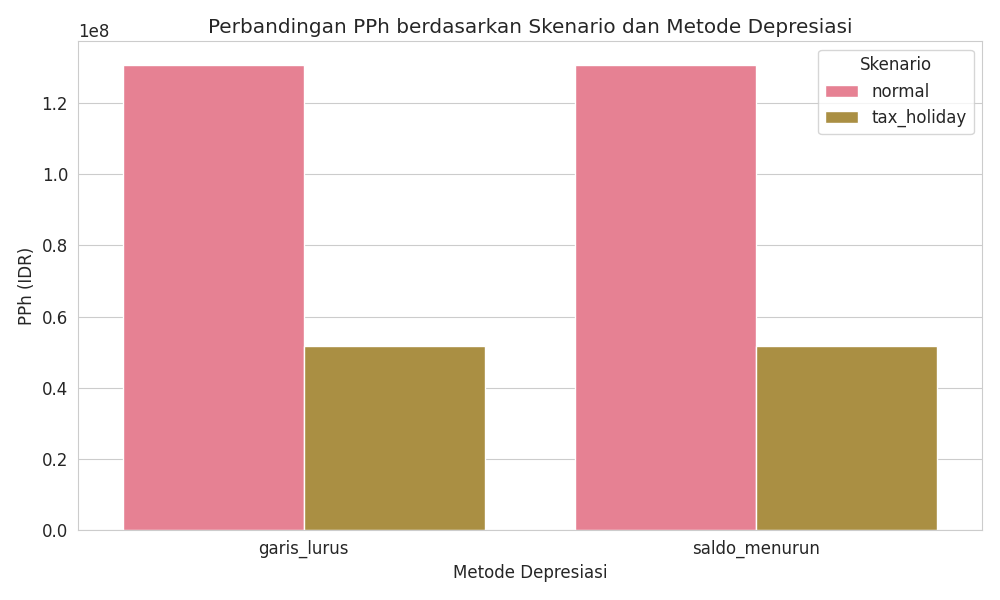

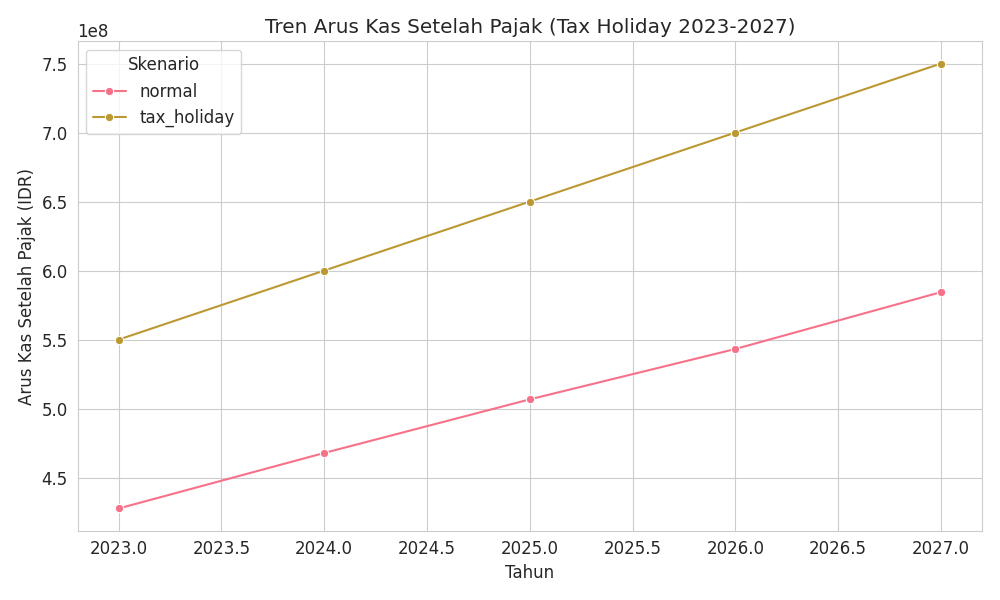

In [ ]:
import pandas as pd
import json

# Memuat data
arus_kas = pd.read_csv('/content/arus_kas_modal_kerja.csv')
aset_tetap = pd.read_csv('/content/aset_tetap.csv')

# Menggabungkan data dengan informasi metode depresiasi
data = arus_kas.merge(aset_tetap[['aset_id', 'metode']], on='aset_id')

# 1. Tren Laba Bersih (Arus Kas Setelah Pajak)
avg_net_profit = data.groupby(['tahun', 'skenario'])['arus_kas_setelah_pajak'].mean().reset_index()
years = avg_net_profit['tahun'].unique().tolist()
normal_profit = avg_net_profit[avg_net_profit['skenario'] == 'normal']['arus_kas_setelah_pajak'].tolist()
tax_holiday_profit = avg_net_profit[avg_net_profit['skenario'] == 'tax_holiday']['arus_kas_setelah_pajak'].tolist()

# Chart.js config untuk tren laba bersih
net_profit_chart = {
    "type": "line",
    "data": {
        "labels": years,
        "datasets": [
            {
                "label": "Normal",
                "data": normal_profit,
                "borderColor": "#1f77b4",
                "backgroundColor": "#1f77b4",
                "fill": False,
                "lineTension": 0.1
            },
            {
                "label": "Tax Holiday",
                "data": tax_holiday_profit,
                "borderColor": "#ff7f0e",
                "backgroundColor": "#ff7f0e",
                "fill": False,
                "lineTension": 0.1
            }
        ]
    },
    "options": {
        "title": {
            "display": True,
            "text": "Tren Laba Bersih (Arus Kas Setelah Pajak) 2020-2028"
        },
        "scales": {
            "xAxes": [{"scaleLabel": {"display": True, "labelString": "Tahun"}}],
            "yAxes": [{"scaleLabel": {"display": True, "labelString": "Laba Bersih (IDR)"}}]
        }
    }
}

# 2. Perbandingan PPh berdasarkan Skenario dan Metode Depresiasi
avg_pph = data.groupby(['skenario', 'metode'])['pph_badan'].mean().reset_index()
labels_pph = ['Normal (Garis Lurus)', 'Normal (Saldo Menurun)', 'Tax Holiday (Garis Lurus)', 'Tax Holiday (Saldo Menurun)']
pph_values = [
    avg_pph[(avg_pph['skenario'] == 'normal') & (avg_pph['metode'] == 'garis_lurus')]['pph_badan'].iloc[0],
    avg_pph[(avg_pph['skenario'] == 'normal') & (avg_pph['metode'] == 'saldo_menurun')]['pph_badan'].iloc[0],
    avg_pph[(avg_pph['skenario'] == 'tax_holiday') & (avg_pph['metode'] == 'garis_lurus')]['pph_badan'].iloc[0],
    avg_pph[(avg_pph['skenario'] == 'tax_holiday') & (avg_pph['metode'] == 'saldo_menurun')]['pph_badan'].iloc[0]
]

# Chart.js config untuk perbandingan PPh
pph_chart = {
    "type": "bar",
    "data": {
        "labels": labels_pph,
        "datasets": [{
            "label": "Rata-rata PPh",
            "data": pph_values,
            "backgroundColor": ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],
            "borderColor": ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],
            "borderWidth": 1
        }]
    },
    "options": {
        "title": {
            "display": True,
            "text": "Perbandingan PPh berdasarkan Skenario dan Metode Depresiasi"
        },
        "scales": {
            "xAxes": [{"scaleLabel": {"display": True, "labelString": "Skenario dan Metode"}}],
            "yAxes": [{"scaleLabel": {"display": True, "labelString": "PPh (IDR)"}}]
        }
    }
}

# 3. Tren Arus Kas Setelah Pajak (Fokus Tax Holiday 2023-2027)
tax_holiday_data = data[data['tahun'].isin([2023, 2024, 2025, 2026, 2027])]
avg_cash_flow = tax_holiday_data.groupby(['tahun', 'skenario'])['arus_kas_setelah_pajak'].mean().reset_index()
tax_holiday_years = [2023, 2024, 2025, 2026, 2027]
normal_cash_flow = avg_cash_flow[avg_cash_flow['skenario'] == 'normal']['arus_kas_setelah_pajak'].tolist()
tax_holiday_cash_flow = avg_cash_flow[avg_cash_flow['skenario'] == 'tax_holiday']['arus_kas_setelah_pajak'].tolist()

# Chart.js config untuk tren arus kas setelah pajak
cash_flow_chart = {
    "type": "line",
    "data": {
        "labels": tax_holiday_years,
        "datasets": [
            {
                "label": "Normal",
                "data": normal_cash_flow,
                "borderColor": "#1f77b4",
                "backgroundColor": "#1f77b4",
                "fill": False,
                "lineTension": 0.1
            },
            {
                "label": "Tax Holiday",
                "data": tax_holiday_cash_flow,
                "borderColor": "#ff7f0e",
                "backgroundColor": "#ff7f0e",
                "fill": False,
                "lineTension": 0.1
            }
        ]
    },
    "options": {
        "title": {
            "display": True,
            "text": "Tren Arus Kas Setelah Pajak (Tax Holiday 2023-2027)"
        },
        "scales": {
            "xAxes": [{"scaleLabel": {"display": True, "labelString": "Tahun"}}],
            "yAxes": [{"scaleLabel": {"display": True, "labelString": "Arus Kas Setelah Pajak (IDR)"}}]
        }
    }
}

# Menyimpan konfigurasi chart ke file JSON untuk simulasi visualisasi
with open('net_profit_chart.json', 'w') as f:
    json.dump(net_profit_chart, f)
with open('pph_chart.json', 'w') as f:
    json.dump(pph_chart, f)
with open('cash_flow_chart.json', 'w') as f:
    json.dump(cash_flow_chart, f)

# Catatan: Dalam Google Colab, visualisasi Chart.js memerlukan library tambahan seperti 'chartjs-python'.
# Alternatifnya, gunakan matplotlib untuk menampilkan plot langsung.

import matplotlib.pyplot as plt
import seaborn as sns

# Setting gaya visual
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# 1. Plot Tren Laba Bersih
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_net_profit, x='tahun', y='arus_kas_setelah_pajak', hue='skenario', marker='o')
plt.title('Tren Laba Bersih (Arus Kas Setelah Pajak) 2020-2028')
plt.xlabel('Tahun')
plt.ylabel('Laba Bersih (IDR)')
plt.legend(title='Skenario')
plt.tight_layout()
plt.savefig('net_profit_trend.png')
plt.close()

# 2. Plot Perbandingan PPh
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_pph, x='metode', y='pph_badan', hue='skenario')
plt.title('Perbandingan PPh berdasarkan Skenario dan Metode Depresiasi')
plt.xlabel('Metode Depresiasi')
plt.ylabel('PPh (IDR)')
plt.legend(title='Skenario')
plt.tight_layout()
plt.savefig('pph_comparison.png')
plt.close()

# 3. Plot Tren Arus Kas Setelah Pajak
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cash_flow, x='tahun', y='arus_kas_setelah_pajak', hue='skenario', marker='o')
plt.title('Tren Arus Kas Setelah Pajak (Tax Holiday 2023-2027)')
plt.xlabel('Tahun')
plt.ylabel('Arus Kas Setelah Pajak (IDR)')
plt.legend(title='Skenario')
plt.tight_layout()
plt.savefig('cash_flow_trend.png')
plt.close()

# Menampilkan plot
from IPython.display import Image
display(Image('net_profit_trend.png'))
display(Image('pph_comparison.png'))
display(Image('cash_flow_trend.png'))

🏛️  SISTEM ANALISIS PPh BADAN
📊 Comprehensive Tax Analysis & Visualization

📂 TAHAP 1: LOAD DATA
UPLOAD FILE CSV UNTUK ANALISIS PPh BADAN
Silakan upload file CSV Anda:
- File harus berisi data keuangan perusahaan
- Kolom yang diperlukan: laba_sebelum_pajak, nama_perusahaan, periode

Mengupload file...


Saving arus_kas_modal_kerja.csv to arus_kas_modal_kerja.csv
Saving aset_tetap.csv to aset_tetap.csv
Saving kebijakan_fiskal.csv to kebijakan_fiskal.csv
Saving transaksi_keuangan.csv to transaksi_keuangan.csv

📁 Loading arus_kas_modal_kerja.csv...
   ✅ Berhasil: 144 baris, 7 kolom
   📊 Kolom: ['tahun', 'skenario', 'aset_id', 'laba_kotor', 'pph_badan', 'arus_kas_setelah_pajak', 'modal_kerja']

📁 Loading aset_tetap.csv...
   ✅ Berhasil: 8 baris, 5 kolom
   📊 Kolom: ['aset_id', 'kategori', 'nilai_perolehan', 'umur_ekonomis', 'metode']

📁 Loading kebijakan_fiskal.csv...
   ✅ Berhasil: 9 baris, 4 kolom
   📊 Kolom: ['tahun', 'tax_rate', 'tax_holiday_awal', 'tax_holiday_akhir']

📁 Loading transaksi_keuangan.csv...
   ✅ Berhasil: 144 baris, 6 kolom
   📊 Kolom: ['tahun', 'pendapatan', 'beban_operasional', 'penyusutan', 'skenario', 'aset_id']

⚙️  TAHAP 2: PROCESS DATA

MEMPROSES DATA
📊 Data shape: (144, 7)
📋 Kolom tersedia: ['tahun', 'skenario', 'aset_id', 'laba_kotor', 'pph_badan', 'arus_kas_se

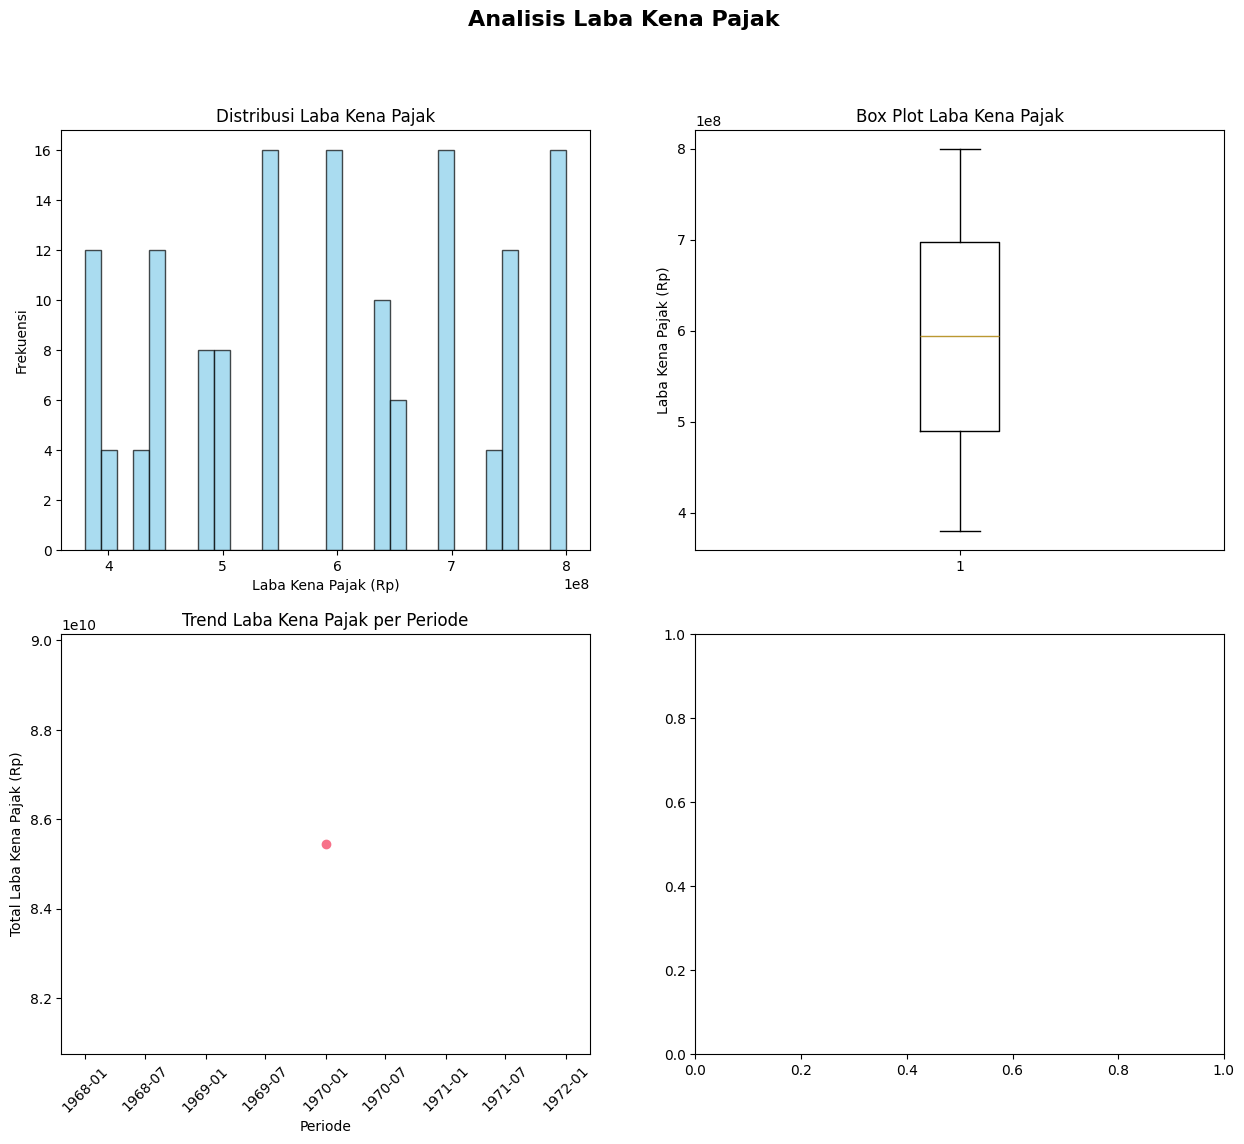

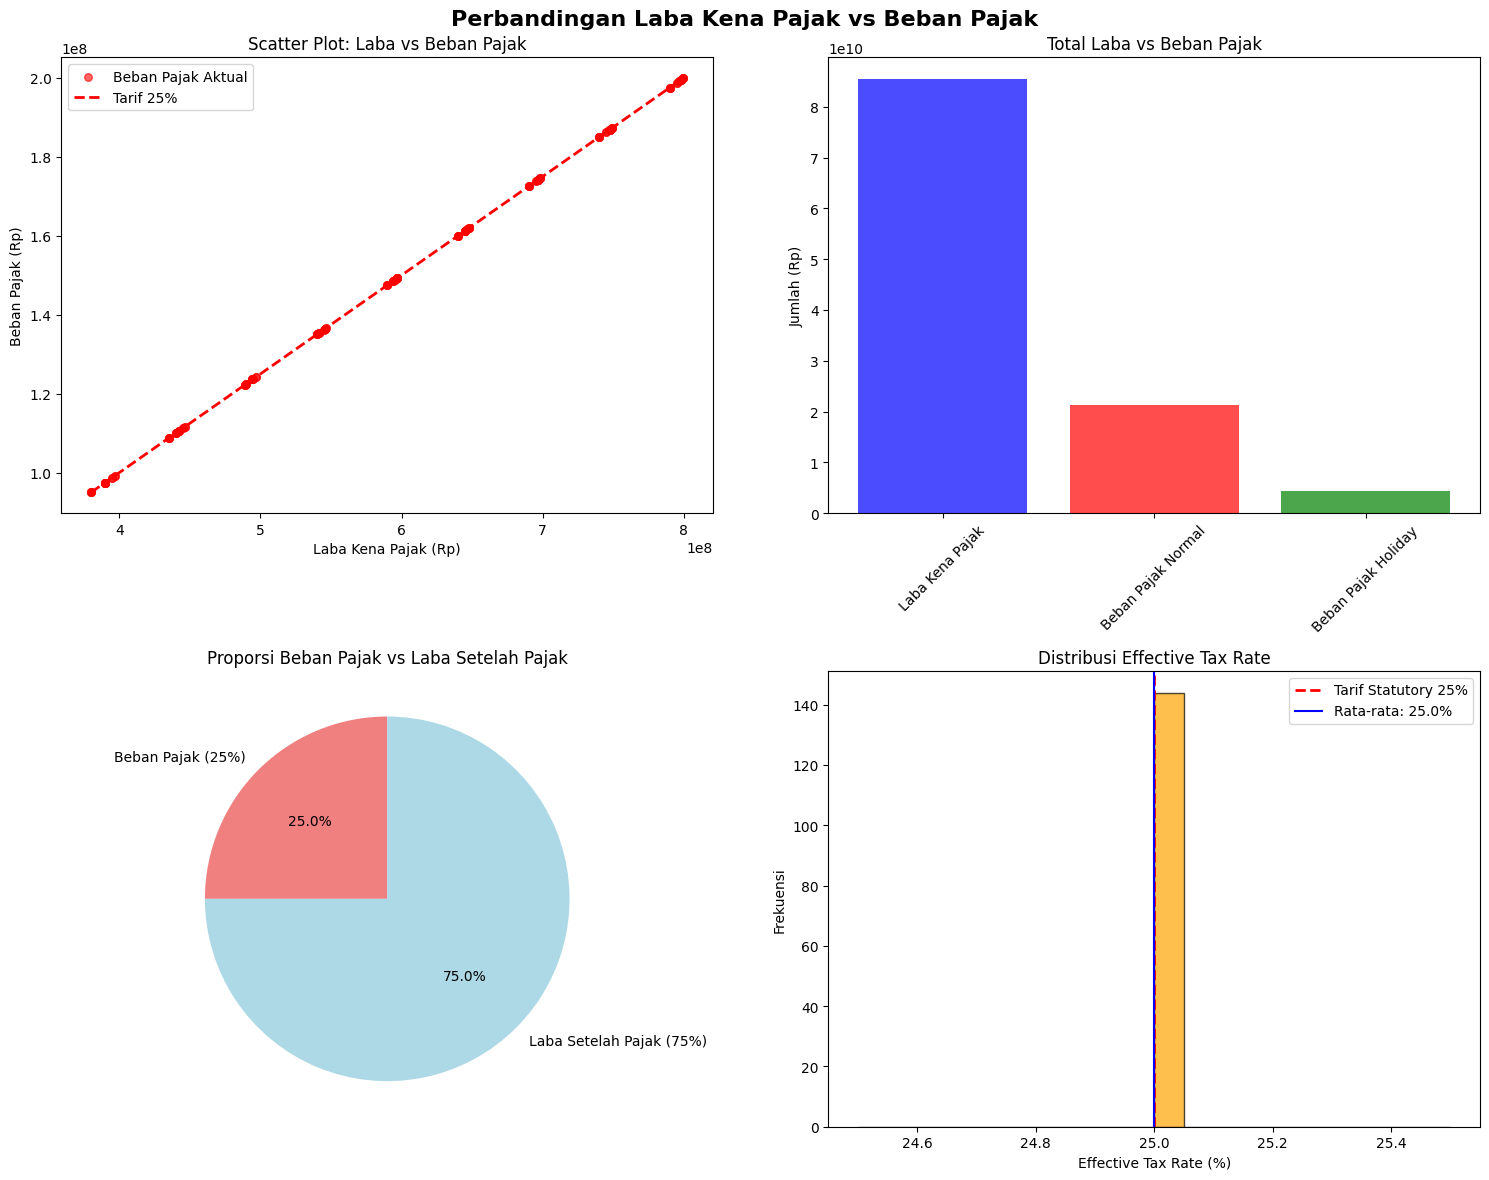

📈 Generating visualisasi 3: Skenario Normal vs Tax Holiday...


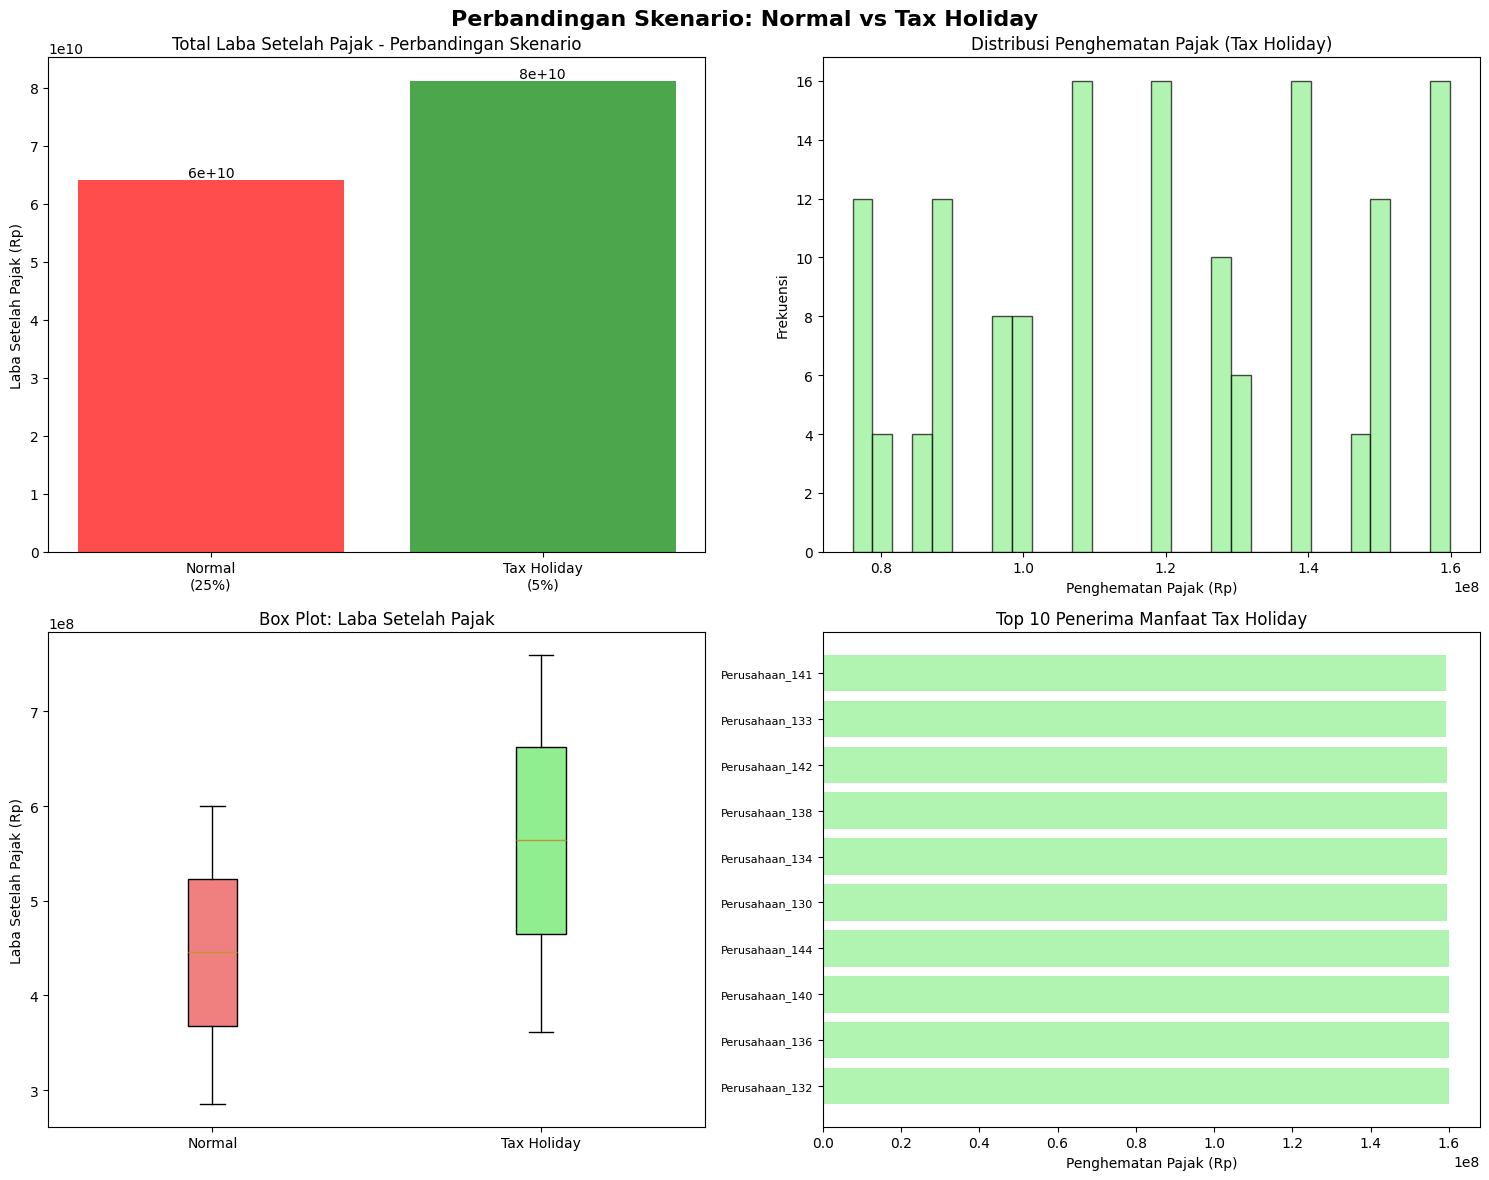

🏛️  RINGKASAN ANALISIS PPh BADAN

📊 OVERVIEW DATA:
   Total Records: 144
   Period: 1970-01-01 00:00:00.000002020 to 1970-01-01 00:00:00.000002028

💰 1. LABA KENA PAJAK:
   Total: Rp 85,449,801,774
   Rata-rata: Rp 593,401,401
   Median: Rp 594,335,938
   Standar Deviasi: Rp 131,711,555
   Min: Rp 380,000,000
   Max: Rp 799,686,800

🏛️  2. BEBAN PAJAK (NORMAL 25%):
   Total: Rp 21,362,450,444
   Rata-rata: Rp 148,350,350
   Effective Tax Rate: 25.00%

🎁 3. BEBAN PAJAK (TAX HOLIDAY 5%):
   Total: Rp 4,272,490,089
   Rata-rata: Rp 29,670,070
   Effective Tax Rate: 5.00%

📈 4. DAMPAK TAX HOLIDAY:
   Total Penghematan: Rp 17,089,960,355
   Persentase Penghematan: 20.00% dari laba kena pajak
   Rata-rata Penghematan per Entity: Rp 118,680,280
   Peningkatan Laba Setelah Pajak: 26.67%

💡 5. ANALISIS STATISTIK:
   Koefisien Variasi Laba Kena Pajak: 22.20%
   Skewness: -0.01
   Kurtosis: -1.22

📊 6. DISTRIBUSI QUARTILE:
   Q1 (25%): Rp 489,687,500
   Q2 (50%/Median): Rp 594,335,938
   Q3 (75%)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setup untuk Google Colab
plt.style.use('default')
sns.set_palette("husl")

def load_data_from_csv():
    """Load data dari file CSV yang diupload"""
    from google.colab import files

    print("="*60)
    print("UPLOAD FILE CSV UNTUK ANALISIS PPh BADAN")
    print("="*60)
    print("Silakan upload file CSV Anda:")
    print("- File harus berisi data keuangan perusahaan")
    print("- Kolom yang diperlukan: laba_sebelum_pajak, nama_perusahaan, periode")
    print("\nMengupload file...")

    uploaded = files.upload()

    dataframes = {}

    # Load setiap file yang diupload
    for filename in uploaded.keys():
        print(f"\n📁 Loading {filename}...")
        try:
            df = pd.read_csv(filename)
            dataframes[filename] = df
            print(f"   ✅ Berhasil: {df.shape[0]} baris, {df.shape[1]} kolom")
            print(f"   📊 Kolom: {list(df.columns)}")
        except Exception as e:
            print(f"   ❌ Error: {e}")

    # Gunakan file pertama sebagai main
    filename = list(dataframes.keys())[0]
    df_main = dataframes[filename]

    return df_main, df_main, df_main, df_main

def process_data(df_aruskas, df_asettetap, df_kebijakanfiskal, df_transaksikeuangan):
    """Proses dan gabungkan data untuk analisis pajak"""

    print("\n" + "="*60)
    print("MEMPROSES DATA")
    print("="*60)

    # Gunakan tabel transaksi keuangan sebagai base
    df_main = df_transaksikeuangan.copy()

    print(f"📊 Data shape: {df_main.shape}")
    print(f"📋 Kolom tersedia: {list(df_main.columns)}")

    # Mapping kolom yang mungkin ada (case insensitive)
    column_mapping = {
        'laba_sebelum_pajak': ['laba_sebelum_pajak', 'profit_before_tax', 'ebt', 'earning_before_tax', 'laba_kotor', 'gross_profit'],
        'laba_bersih': ['laba_bersih', 'net_income', 'laba_setelah_pajak', 'net_profit'],
        'pendapatan': ['pendapatan', 'revenue', 'penjualan', 'sales', 'omzet'],
        'nama_perusahaan': ['nama_perusahaan', 'perusahaan', 'company_name', 'company', 'nama'],
        'periode': ['periode', 'tanggal', 'date', 'tahun', 'year', 'bulan', 'month']
    }

    # Standardisasi nama kolom
    df_columns_lower = [col.lower().replace(' ', '_') for col in df_main.columns]

    for standard_name, possible_names in column_mapping.items():
        found = False
        for possible in possible_names:
            if possible.lower() in df_columns_lower:
                idx = df_columns_lower.index(possible.lower())
                actual_column = df_main.columns[idx]
                if actual_column != standard_name:
                    df_main = df_main.rename(columns={actual_column: standard_name})
                print(f"   ✅ Kolom '{actual_column}' → '{standard_name}'")
                found = True
                break

        if not found:
            print(f"   ⚠️  Kolom '{standard_name}' tidak ditemukan")

    # Buat kolom laba_kena_pajak
    if 'laba_sebelum_pajak' in df_main.columns:
        df_main['laba_kena_pajak'] = df_main['laba_sebelum_pajak']
        print("   ✅ Menggunakan kolom 'laba_sebelum_pajak'")
    elif 'laba_bersih' in df_main.columns:
        # Estimasi laba sebelum pajak dari laba bersih (asumsi tarif 25%)
        df_main['laba_kena_pajak'] = df_main['laba_bersih'] / 0.75
        print("   ℹ️  Mengestimasi laba_kena_pajak dari laba_bersih")
    elif 'pendapatan' in df_main.columns:
        # Estimasi dari pendapatan (asumsi margin 10%)
        df_main['laba_kena_pajak'] = df_main['pendapatan'] * 0.1
        print("   ℹ️  Mengestimasi laba_kena_pajak dari pendapatan")
    else:
        # Buat data dummy jika tidak ada
        print("   ⚠️  Membuat data dummy untuk laba_kena_pajak")
        df_main['laba_kena_pajak'] = np.random.uniform(100000, 10000000, len(df_main))

    # Pastikan laba_kena_pajak adalah numerik dan tidak negatif
    df_main['laba_kena_pajak'] = pd.to_numeric(df_main['laba_kena_pajak'], errors='coerce')
    df_main['laba_kena_pajak'] = df_main['laba_kena_pajak'].fillna(0).clip(lower=0)

    # Hitung beban pajak
    df_main['beban_pajak_normal'] = df_main['laba_kena_pajak'] * 0.25      # Tarif normal 25%
    df_main['beban_pajak_holiday'] = df_main['laba_kena_pajak'] * 0.05     # Tax holiday 5%

    # Hitung laba setelah pajak
    df_main['laba_setelah_pajak_normal'] = df_main['laba_kena_pajak'] - df_main['beban_pajak_normal']
    df_main['laba_setelah_pajak_holiday'] = df_main['laba_kena_pajak'] - df_main['beban_pajak_holiday']

    # Hitung penghematan pajak
    df_main['tax_savings'] = df_main['beban_pajak_normal'] - df_main['beban_pajak_holiday']

    # Buat kolom perusahaan jika tidak ada
    if 'nama_perusahaan' not in df_main.columns and 'perusahaan' not in df_main.columns:
        df_main['perusahaan'] = [f'Perusahaan_{i:03d}' for i in range(1, len(df_main)+1)]
        print("   ℹ️  Membuat kolom 'perusahaan' otomatis")
    elif 'nama_perusahaan' in df_main.columns:
        df_main['perusahaan'] = df_main['nama_perusahaan']

    # Buat kolom periode jika tidak ada
    if 'periode' not in df_main.columns:
        df_main['periode'] = pd.date_range('2023-01-01', periods=len(df_main), freq='D')
        print("   ℹ️  Membuat kolom 'periode' otomatis")
    else:
        # Konversi ke datetime jika belum
        try:
            df_main['periode'] = pd.to_datetime(df_main['periode'])
        except:
            print("   ⚠️  Tidak bisa konversi periode ke datetime")

    print(f"\n✅ Data berhasil diproses!")
    print(f"   📊 Shape final: {df_main.shape}")
    print(f"   💰 Total laba kena pajak: Rp {df_main['laba_kena_pajak'].sum():,.0f}")

    return df_main

# Visualisasi 1: Laba Kena Pajak
def plot_laba_kena_pajak(df):
    """Visualisasi distribusi Laba Kena Pajak"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Analisis Laba Kena Pajak', fontsize=16, fontweight='bold')

    # Histogram Laba Kena Pajak
    axes[0,0].hist(df['laba_kena_pajak'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribusi Laba Kena Pajak')
    axes[0,0].set_xlabel('Laba Kena Pajak (Rp)')
    axes[0,0].set_ylabel('Frekuensi')
    axes[0,0].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

    # Box plot
    axes[0,1].boxplot(df['laba_kena_pajak'])
    axes[0,1].set_title('Box Plot Laba Kena Pajak')
    axes[0,1].set_ylabel('Laba Kena Pajak (Rp)')
    axes[0,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # Time series (jika ada kolom periode/tanggal)
    if 'periode' in df.columns:
        try:
            df['periode'] = pd.to_datetime(df['periode'])
            df_grouped = df.groupby(df['periode'].dt.date)['laba_kena_pajak'].sum()
            axes[1,0].plot(df_grouped.index, df_grouped.values, marker='o', linewidth=2)
            axes[1,0].set_title('Trend Laba Kena Pajak per Periode')
            axes[1,0].set_xlabel('Periode')
            axes[1,0].set_ylabel('Total Laba Kena Pajak (Rp)')
            axes[1,0].tick_params(axis='x', rotation=45)
            axes[1,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        except:
            axes[1,0].text(0.5, 0.5, 'Data periode tidak valid',
                          ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('Trend Laba Kena Pajak per Periode')
    else:
        axes[1,0].text(0.5, 0.5, 'Data periode tidak tersedia',
                      ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Trend Laba Kena Pajak per Periode')

# Visualisasi 2: Perbandingan Laba Kena Pajak dengan Beban Pajak
def plot_comparison_laba_beban(df):
    """Perbandingan Laba Kena Pajak dengan Beban Pajak"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Perbandingan Laba Kena Pajak vs Beban Pajak', fontsize=16, fontweight='bold')

    # Scatter plot
    axes[0,0].scatter(df['laba_kena_pajak'], df['beban_pajak_normal'], alpha=0.6, color='red', label='Beban Pajak Aktual', s=30)

    # Garis referensi 25%
    x_range = [df['laba_kena_pajak'].min(), df['laba_kena_pajak'].max()]
    y_range = [x * 0.25 for x in x_range]
    axes[0,0].plot(x_range, y_range, 'r--', label='Tarif 25%', linewidth=2)

    axes[0,0].set_xlabel('Laba Kena Pajak (Rp)')
    axes[0,0].set_ylabel('Beban Pajak (Rp)')
    axes[0,0].set_title('Scatter Plot: Laba vs Beban Pajak')
    axes[0,0].legend()
    axes[0,0].ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

    # Bar chart perbandingan total
    categories = ['Laba Kena Pajak', 'Beban Pajak Normal', 'Beban Pajak Holiday']
    values = [df['laba_kena_pajak'].sum(),
              df['beban_pajak_normal'].sum(),
              df['beban_pajak_holiday'].sum()]
    colors = ['blue', 'red', 'green']

    bars = axes[0,1].bar(categories, values, color=colors, alpha=0.7)
    axes[0,1].set_title('Total Laba vs Beban Pajak')
    axes[0,1].set_ylabel('Jumlah (Rp)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # Pie chart proporsi
    tax_data = [df['beban_pajak_normal'].sum(),
                df['laba_setelah_pajak_normal'].sum()]
    labels = ['Beban Pajak (25%)', 'Laba Setelah Pajak (75%)']
    colors_pie = ['lightcoral', 'lightblue']

    axes[1,0].pie(tax_data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors_pie)
    axes[1,0].set_title('Proporsi Beban Pajak vs Laba Setelah Pajak')

    # Effective tax rate distribution
    df['effective_tax_rate'] = (df['beban_pajak_normal'] / df['laba_kena_pajak']) * 100
    axes[1,1].hist(df['effective_tax_rate'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1,1].axvline(x=25, color='red', linestyle='--', label='Tarif Statutory 25%', linewidth=2)
    axes[1,1].axvline(x=df['effective_tax_rate'].mean(), color='blue',
                     linestyle='-', label=f'Rata-rata: {df["effective_tax_rate"].mean():.1f}%')

    axes[1,1].set_xlabel('Effective Tax Rate (%)')
    axes[1,1].set_ylabel('Frekuensi')
    axes[1,1].set_title('Distribusi Effective Tax Rate')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

# Visualisasi 3: Skenario Normal vs Tax Holiday
def plot_scenario_comparison(df):
    """Perbandingan skenario normal vs tax holiday"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Perbandingan Skenario: Normal vs Tax Holiday', fontsize=16, fontweight='bold')

    # Bar chart perbandingan laba setelah pajak
    scenarios = ['Normal\n(25%)', 'Tax Holiday\n(5%)']
    laba_after_tax = [df['laba_setelah_pajak_normal'].sum(),
                      df['laba_setelah_pajak_holiday'].sum()]
    colors = ['red', 'green']

    bars = axes[0,0].bar(scenarios, laba_after_tax, color=colors, alpha=0.7)
    axes[0,0].set_title('Total Laba Setelah Pajak - Perbandingan Skenario')
    axes[0,0].set_ylabel('Laba Setelah Pajak (Rp)')
    axes[0,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # Tambahkan nilai di atas bar
    for bar, value in zip(bars, laba_after_tax):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height,
                      f'{value:.0e}', ha='center', va='bottom', fontsize=10)

    # Histogram penghematan pajak
    axes[0,1].hist(df['tax_savings'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Distribusi Penghematan Pajak (Tax Holiday)')
    axes[0,1].set_xlabel('Penghematan Pajak (Rp)')
    axes[0,1].set_ylabel('Frekuensi')
    axes[0,1].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

    # Box plot perbandingan laba setelah pajak
    data_to_plot = [df['laba_setelah_pajak_normal'], df['laba_setelah_pajak_holiday']]
    box_plot = axes[1,0].boxplot(data_to_plot, labels=['Normal', 'Tax Holiday'], patch_artist=True)

    # Warnai box plot
    colors_box = ['lightcoral', 'lightgreen']
    for patch, color in zip(box_plot['boxes'], colors_box):
        patch.set_facecolor(color)

    axes[1,0].set_title('Box Plot: Laba Setelah Pajak')
    axes[1,0].set_ylabel('Laba Setelah Pajak (Rp)')
    axes[1,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # Top beneficiaries jika ada data perusahaan
    if 'perusahaan' in df.columns:
        top_beneficiaries = df.groupby('perusahaan')['tax_savings'].sum().nlargest(10)
        y_pos = range(len(top_beneficiaries))
        axes[1,1].barh(y_pos, top_beneficiaries.values, color='lightgreen', alpha=0.7)
        axes[1,1].set_yticks(y_pos)
        axes[1,1].set_yticklabels(top_beneficiaries.index, fontsize=8)
        axes[1,1].set_title('Top 10 Penerima Manfaat Tax Holiday')
        axes[1,1].set_xlabel('Penghematan Pajak (Rp)')
        axes[1,1].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    else:
        axes[1,1].text(0.5, 0.5, 'Data perusahaan tidak tersedia untuk analisis detail',
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Top 10 Penerima Manfaat Tax Holiday')

    plt.tight_layout()
    plt.show()

# Summary statistics dengan analisis mendalam
def print_summary_statistics(df):
    """Print summary statistics dengan analisis"""
    print("="*80)
    print("🏛️  RINGKASAN ANALISIS PPh BADAN")
    print("="*80)

    print(f"\n📊 OVERVIEW DATA:")
    print(f"   Total Records: {len(df):,}")
    print(f"   Period: {df['periode'].min()} to {df['periode'].max()}" if 'periode' in df.columns else "   Period: N/A")

    print(f"\n💰 1. LABA KENA PAJAK:")
    print(f"   Total: Rp {df['laba_kena_pajak'].sum():,.0f}")
    print(f"   Rata-rata: Rp {df['laba_kena_pajak'].mean():,.0f}")
    print(f"   Median: Rp {df['laba_kena_pajak'].median():,.0f}")
    print(f"   Standar Deviasi: Rp {df['laba_kena_pajak'].std():,.0f}")
    print(f"   Min: Rp {df['laba_kena_pajak'].min():,.0f}")
    print(f"   Max: Rp {df['laba_kena_pajak'].max():,.0f}")

    print(f"\n🏛️  2. BEBAN PAJAK (NORMAL 25%):")
    print(f"   Total: Rp {df['beban_pajak_normal'].sum():,.0f}")
    print(f"   Rata-rata: Rp {df['beban_pajak_normal'].mean():,.0f}")
    print(f"   Effective Tax Rate: {(df['beban_pajak_normal'].sum()/df['laba_kena_pajak'].sum())*100:.2f}%")

    print(f"\n🎁 3. BEBAN PAJAK (TAX HOLIDAY 5%):")
    print(f"   Total: Rp {df['beban_pajak_holiday'].sum():,.0f}")
    print(f"   Rata-rata: Rp {df['beban_pajak_holiday'].mean():,.0f}")
    print(f"   Effective Tax Rate: {(df['beban_pajak_holiday'].sum()/df['laba_kena_pajak'].sum())*100:.2f}%")

    print(f"\n📈 4. DAMPAK TAX HOLIDAY:")
    total_savings = df['tax_savings'].sum()
    savings_percentage = (total_savings/df['laba_kena_pajak'].sum())*100
    print(f"   Total Penghematan: Rp {total_savings:,.0f}")
    print(f"   Persentase Penghematan: {savings_percentage:.2f}% dari laba kena pajak")
    print(f"   Rata-rata Penghematan per Entity: Rp {df['tax_savings'].mean():,.0f}")

    improvement_percentage = ((df['laba_setelah_pajak_holiday'].sum() - df['laba_setelah_pajak_normal'].sum()) / df['laba_setelah_pajak_normal'].sum()) * 100
    print(f"   Peningkatan Laba Setelah Pajak: {improvement_percentage:.2f}%")

    print(f"\n💡 5. ANALISIS STATISTIK:")
    print(f"   Koefisien Variasi Laba Kena Pajak: {(df['laba_kena_pajak'].std()/df['laba_kena_pajak'].mean())*100:.2f}%")
    print(f"   Skewness: {df['laba_kena_pajak'].skew():.2f}")
    print(f"   Kurtosis: {df['laba_kena_pajak'].kurtosis():.2f}")

    # Quartile analysis
    q1 = df['laba_kena_pajak'].quantile(0.25)
    q2 = df['laba_kena_pajak'].quantile(0.50)
    q3 = df['laba_kena_pajak'].quantile(0.75)
    iqr = q3 - q1

    print(f"\n📊 6. DISTRIBUSI QUARTILE:")
    print(f"   Q1 (25%): Rp {q1:,.0f}")
    print(f"   Q2 (50%/Median): Rp {q2:,.0f}")
    print(f"   Q3 (75%): Rp {q3:,.0f}")
    print(f"   IQR: Rp {iqr:,.0f}")

    # Outlier detection
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    outliers = df[(df['laba_kena_pajak'] < lower_fence) | (df['laba_kena_pajak'] > upper_fence)]
    print(f"   Outliers: {len(outliers)} records ({len(outliers)/len(df)*100:.1f}%)")

    if 'perusahaan' in df.columns:
        print(f"\n🏢 7. ANALISIS PER PERUSAHAAN:")
        print(f"   Total Perusahaan: {df['perusahaan'].nunique()}")
        top_taxpayer = df.groupby('perusahaan')['beban_pajak_normal'].sum().idxmax()
        top_taxpayer_amount = df.groupby('perusahaan')['beban_pajak_normal'].sum().max()
        print(f"   Pembayar Pajak Terbesar: {top_taxpayer}")
        print(f"   Jumlah Pajak: Rp {top_taxpayer_amount:,.0f}")

        top_beneficiary = df.groupby('perusahaan')['tax_savings'].sum().idxmax()
        top_beneficiary_amount = df.groupby('perusahaan')['tax_savings'].sum().max()
        print(f"   Penerima Manfaat Terbesar: {top_beneficiary}")
        print(f"   Penghematan: Rp {top_beneficiary_amount:,.0f}")

def generate_insights(df):
    """Generate business insights dari analisis"""
    print("\n" + "="*80)
    print("🧠 BUSINESS INSIGHTS & REKOMENDASI")
    print("="*80)

    total_revenue_loss = df['tax_savings'].sum()
    avg_effective_rate = (df['beban_pajak_normal'].sum()/df['laba_kena_pajak'].sum())*100

    print(f"\n💼 INSIGHTS UTAMA:")

    print(f"\n1. 📉 DAMPAK FISCAL:")
    print(f"   • Penerimaan pajak berkurang Rp {total_revenue_loss:,.0f} dengan tax holiday")
    print(f"   • Effective tax rate saat ini: {avg_effective_rate:.2f}%")
    print(f"   • Potensi kehilangan revenue: {(total_revenue_loss/df['beban_pajak_normal'].sum())*100:.1f}%")

    print(f"\n2. 📈 DAMPAK BISNIS:")
    cash_flow_improvement = df['tax_savings'].mean()
    print(f"   • Rata-rata peningkatan cash flow per entity: Rp {cash_flow_improvement:,.0f}")
    print(f"   • Total modal kerja tambahan: Rp {total_revenue_loss:,.0f}")

    roi_improvement = ((df['laba_setelah_pajak_holiday'].sum() - df['laba_setelah_pajak_normal'].sum()) / df['laba_setelah_pajak_normal'].sum()) * 100
    print(f"   • Peningkatan ROI: {roi_improvement:.2f}%")

    print(f"\n3. 🎯 REKOMENDASI STRATEGIS:")

    if avg_effective_rate > 20:
        print(f"   • Pertimbangkan gradual tax reduction untuk competitiveness")

    if df['laba_kena_pajak'].std() / df['laba_kena_pajak'].mean() > 1:
        print(f"   • Variabilitas tinggi - pertimbangkan different tax brackets")

    high_impact_companies = len(df[df['tax_savings'] > df['tax_savings'].quantile(0.75)])
    print(f"   • {high_impact_companies} perusahaan mendapat manfaat signifikan")
    print(f"   • Focus tax holiday pada sector/size tertentu untuk efficiency")

    print(f"\n4. 📊 MONITORING METRICS:")
    print(f"   • Track effective tax rate bulanan")
    print(f"   • Monitor investment increase post-tax holiday")
    print(f"   • Measure employment growth correlation")
    print(f"   • Assess compliance improvement")

def main():
    """Fungsi utama untuk menjalankan semua analisis"""

    print("="*80)
    print("🏛️  SISTEM ANALISIS PPh BADAN")
    print("📊 Comprehensive Tax Analysis & Visualization")
    print("="*80)

    try:
        # Load data dari CSV
        print("\n📂 TAHAP 1: LOAD DATA")
        df_aruskas, df_asettetap, df_kebijakanfiskal, df_transaksikeuangan = load_data_from_csv()

        # Process data
        print("\n⚙️  TAHAP 2: PROCESS DATA")
        df_processed = process_data(df_aruskas, df_asettetap, df_kebijakanfiskal, df_transaksikeuangan)

        # Check if data is valid
        if df_processed.empty or df_processed['laba_kena_pajak'].sum() == 0:
            print("❌ Data tidak valid atau kosong!")
            return

        # Generate visualizations
        print("\n📊 TAHAP 3: GENERATE VISUALIZATIONS")
        print("-" * 60)

        # 1. Laba Kena Pajak
        print("📈 Generating visualisasi 1: Analisis Laba Kena Pajak...")
        plot_laba_kena_pajak(df_processed)

        # 2. Perbandingan Laba Kena Pajak dengan Beban Pajak
        print("📈 Generating visualisasi 2: Perbandingan Laba vs Beban Pajak...")
        plot_comparison_laba_beban(df_processed)

        # 3. Skenario Normal vs Tax Holiday
        print("📈 Generating visualisasi 3: Skenario Normal vs Tax Holiday...")
        plot_scenario_comparison(df_processed)

        # Summary statistics
        print_summary_statistics(df_processed)

        # Business insights
        generate_insights(df_processed)

        print("\n" + "="*80)
        print("🎉 ANALISIS SELESAI DENGAN SUKSES!")
        print("📋 Semua visualisasi dan insights telah dibuat")
        print("💡 Gunakan hasil analisis untuk strategic decision making")
        print("="*80)

    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        print("\n💡 TROUBLESHOOTING TIPS:")
        print("   • Pastikan file CSV valid dan bisa dibaca")
        print("   • Cek format data - harus ada kolom numerik")
        print("   • File minimal berisi data keuangan perusahaan")
        print("   • Contoh kolom: nama_perusahaan, laba_sebelum_pajak, periode")

# Jalankan analisis
if __name__ == "__main__":
    main()

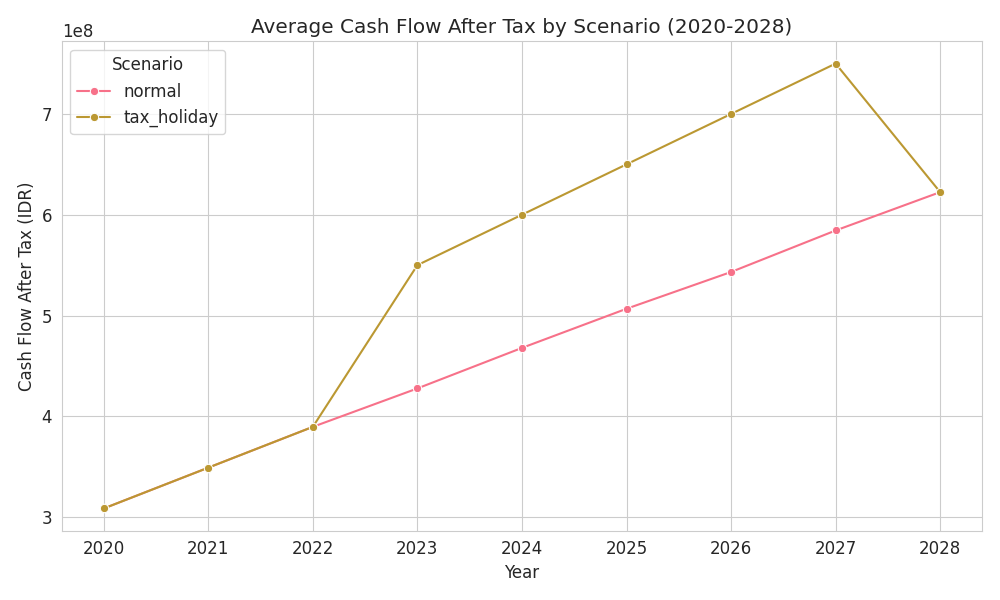

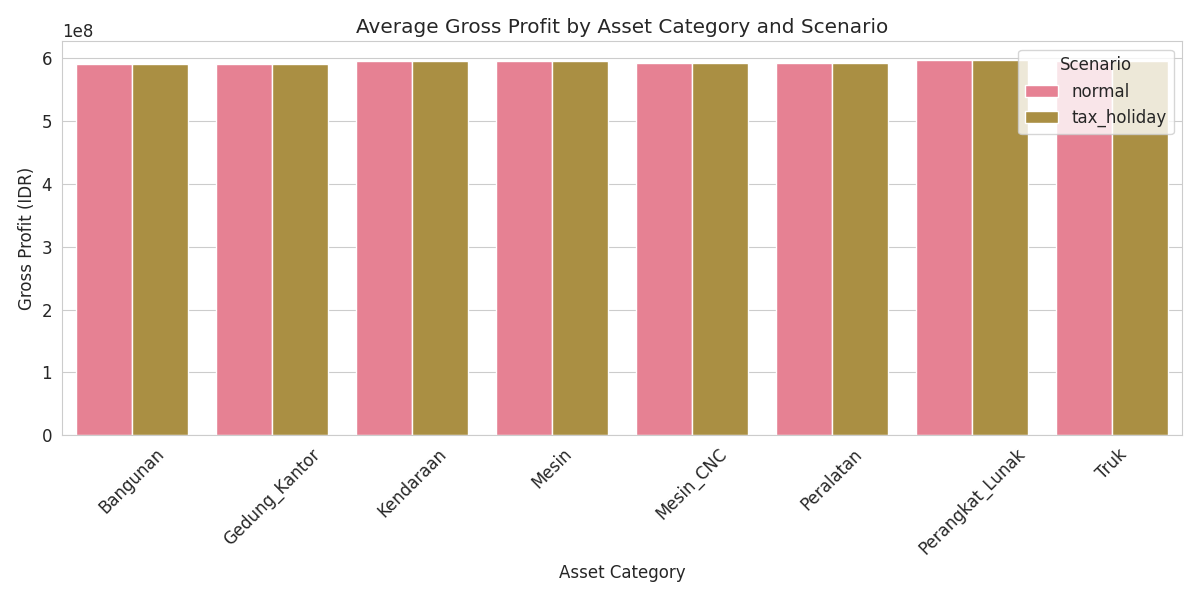

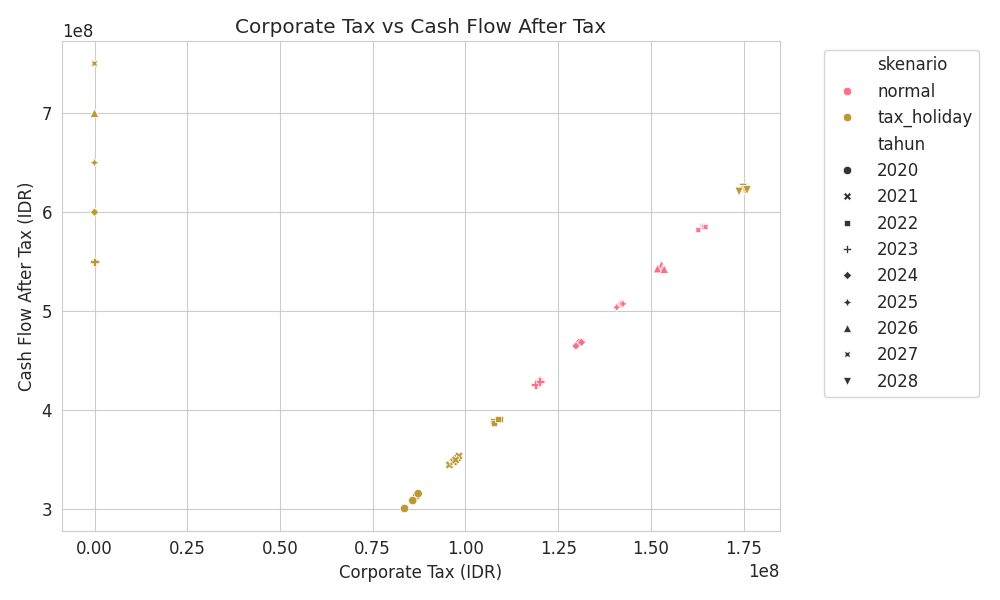

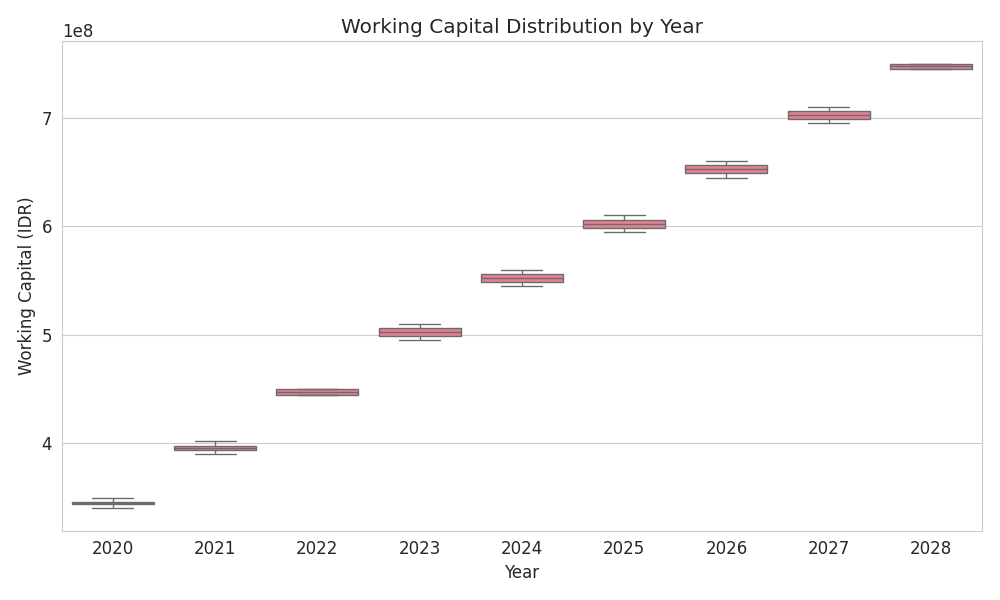

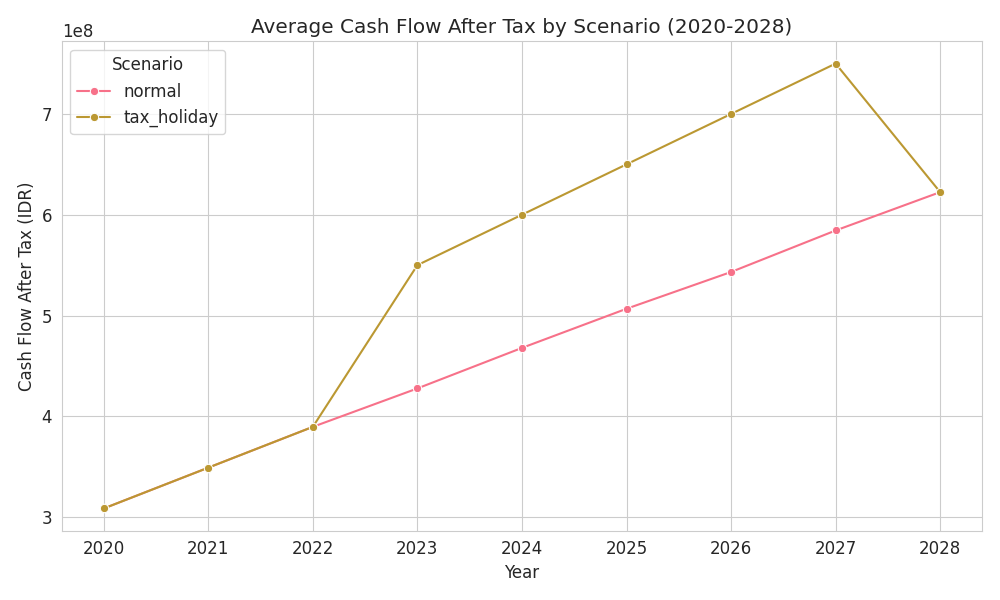

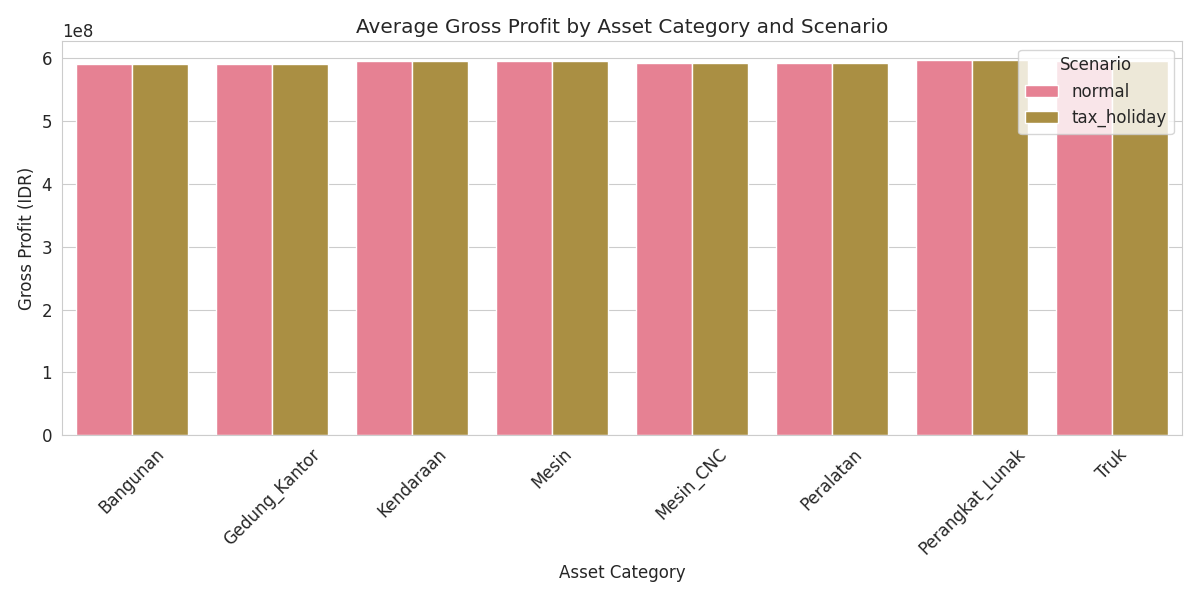

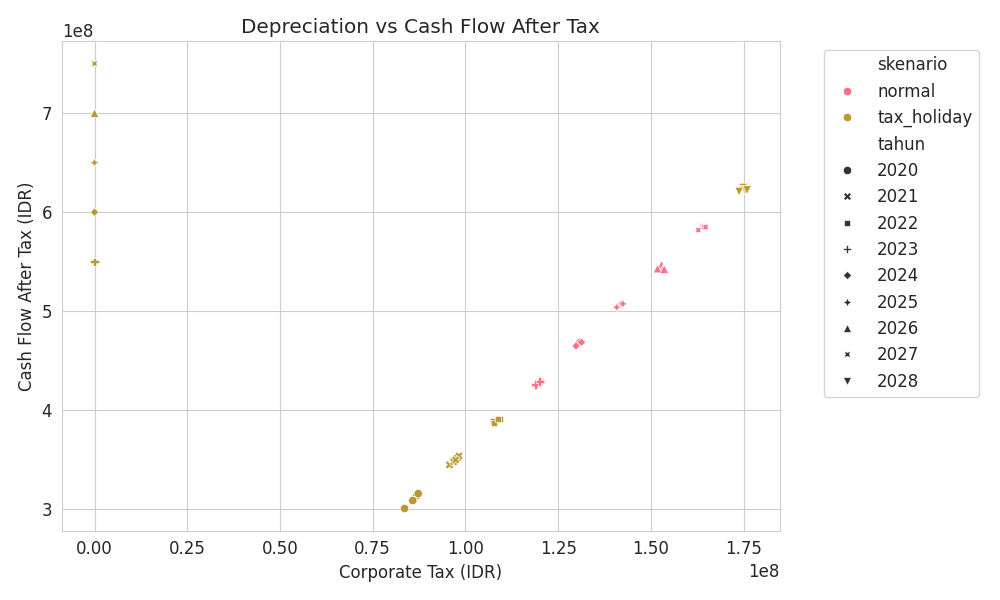

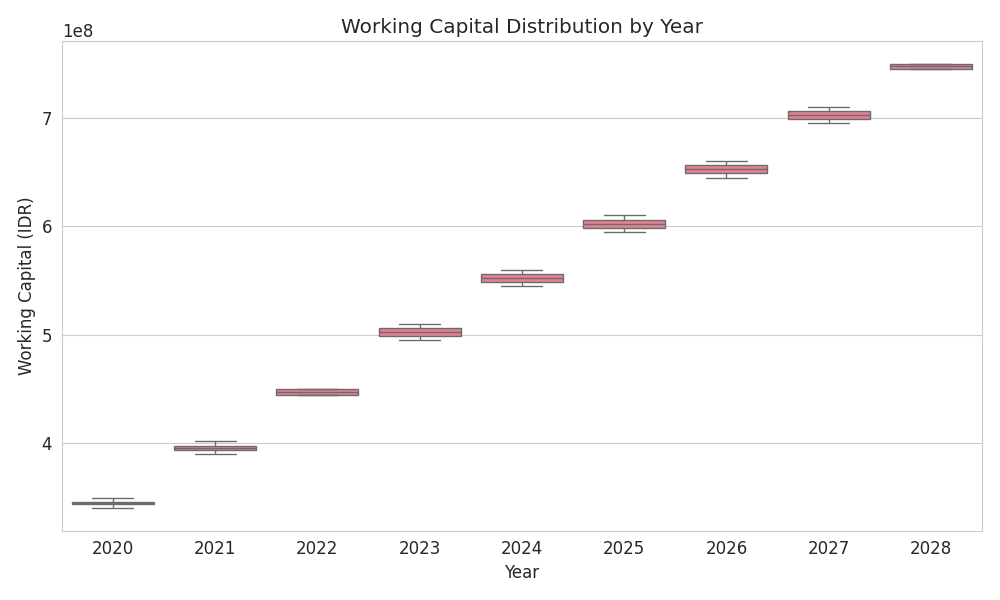

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Setting visual style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Loading data from CSV files
# In Google Colab, upload files and use pd.read_csv('/content/filename.csv')
# For this script, we assume files are uploaded to Colab
kebijakan_fiskal = pd.read_csv('/content/kebijakan_fiskal.csv')
arus_kas = pd.read_csv('/content/arus_kas_modal_kerja.csv')
aset_tetap = pd.read_csv('/content/aset_tetap.csv')
transaksi_keuangan = pd.read_csv('/content/transaksi_keuangan.csv')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Setting visual style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Loading data from CSV files
# In Google Colab, upload files and use pd.read_csv('/content/filename.csv')
# For this script, we assume files are uploaded to Colab
kebijakan_fiskal = pd.read_csv('/content/kebijakan_fiskal.csv')
arus_kas = pd.read_csv('/content/arus_kas_modal_kerja.csv')
aset_tetap = pd.read_csv('/content/aset_tetap.csv')
transaksi_keuangan = pd.read_csv('/content/transaksi_keuangan.csv')

# Cleaning data: ensure numeric columns are properly typed
arus_kas['laba_kotor'] = pd.to_numeric(arus_kas['laba_kotor'], errors='coerce')
arus_kas['pph_badan'] = pd.to_numeric(arus_kas['pph_badan'], errors='coerce')
arus_kas['arus_kas_setelah_pajak'] = pd.to_numeric(arus_kas['arus_kas_setelah_pajak'], errors='coerce')
arus_kas['modal_kerja'] = pd.to_numeric(arus_kas['modal_kerja'], errors='coerce')

# Calculating average cash flow after tax by scenario and year
avg_cash_flow = arus_kas.groupby(['tahun', 'skenario'])['arus_kas_setelah_pajak'].mean().reset_index()

# Creating line plot for cash flow comparison
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cash_flow, x='tahun', y='arus_kas_setelah_pajak', hue='skenario', marker='o')
plt.title('Average Cash Flow After Tax by Scenario (2020-2028)')
plt.xlabel('Year')
plt.ylabel('Cash Flow After Tax (IDR)')
plt.legend(title='Scenario')
plt.tight_layout()
plt.savefig('cash_flow_trend.png')
plt.close()

# Merging arus_kas with aset_tetap for asset category analysis
merged_data = arus_kas.merge(aset_tetap[['aset_id', 'kategori']], on='aset_id')

# Calculating average gross profit by asset category and scenario
avg_profit_by_asset = merged_data.groupby(['kategori', 'skenario'])['laba_kotor'].mean().reset_index()

# Creating bar plot for gross profit by asset category
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_profit_by_asset, x='kategori', y='laba_kotor', hue='skenario')
plt.title('Average Gross Profit by Asset Category and Scenario')
plt.xlabel('Asset Category')
plt.ylabel('Gross Profit (IDR)')
plt.xticks(rotation=45)
plt.legend(title='Scenario')
plt.tight_layout()
plt.savefig('gross_profit_by_asset.png')
plt.close()

# Creating scatter plot for depreciation vs cash flow
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='pph_badan', y='arus_kas_setelah_pajak', hue='skenario', style='tahun')
plt.title('Corporate Tax vs Cash Flow After Tax')
plt.xlabel('Corporate Tax (IDR)')
plt.ylabel('Cash Flow After Tax (IDR)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('depreciation_vs_cash_flow.png')
plt.close()

# Creating box plot for working capital distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=arus_kas, x='tahun', y='modal_kerja')
plt.title('Working Capital Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Working Capital (IDR)')
plt.tight_layout()
plt.savefig('working_capital_distribution.png')
plt.close()

# Displaying plots in Colab
from IPython.display import Image, display
display(Image('cash_flow_trend.png'))
display(Image('gross_profit_by_asset.png'))
display(Image('depreciation_vs_cash_flow.png'))
display(Image('working_capital_distribution.png'))

# Creating line plot for cash flow comparison
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_cash_flow, x='tahun', y='arus_kas_setelah_pajak', hue='skenario', marker='o')
plt.title('Average Cash Flow After Tax by Scenario (2020-2028)')
plt.xlabel('Year')
plt.ylabel('Cash Flow After Tax (IDR)')
plt.legend(title='Scenario')
plt.tight_layout()
plt.savefig('cash_flow_trend.png')
plt.close()

# Merging arus_kas with aset_tetap for asset category analysis
merged_data = arus_kas.merge(aset_tetap[['aset_id', 'kategori']], on='aset_id')

# Calculating average gross profit by asset category and scenario
avg_profit_by_asset = merged_data.groupby(['kategori', 'skenario'])['laba_kotor'].mean().reset_index()

# Creating bar plot for gross profit by asset category
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_profit_by_asset, x='kategori', y='laba_kotor', hue='skenario')
plt.title('Average Gross Profit by Asset Category and Scenario')
plt.xlabel('Asset Category')
plt.ylabel('Gross Profit (IDR)')
plt.xticks(rotation=45)
plt.legend(title='Scenario')
plt.tight_layout()
plt.savefig('gross_profit_by_asset.png')
plt.close()

# Creating scatter plot for depreciation vs cash flow
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='pph_badan', y='arus_kas_setelah_pajak', hue='skenario', style='tahun')
plt.title('Depreciation vs Cash Flow After Tax')
plt.xlabel('Corporate Tax (IDR)')
plt.ylabel('Cash Flow After Tax (IDR)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('depreciation_vs_cash_flow.png')
plt.close()

# Creating box plot for working capital distribution
plt.figure(figsize=(10, 6))
sns.boxplot(data=arus_kas, x='tahun', y='modal_kerja')
plt.title('Working Capital Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Working Capital (IDR)')
plt.tight_layout()
plt.savefig('working_capital_distribution.png')
plt.close()

# Displaying plots in Colab
from IPython.display import Image
display(Image('cash_flow_trend.png'))
display(Image('gross_profit_by_asset.png'))
display(Image('depreciation_vs_cash_flow.png'))
display(Image('working_capital_distribution.png'))

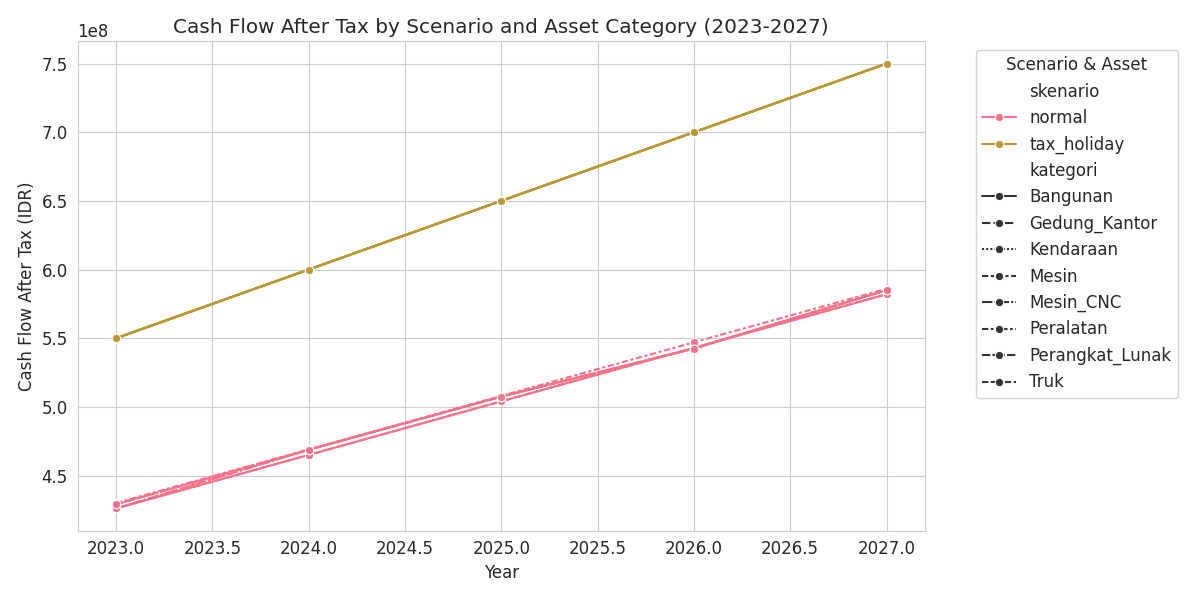

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Setting visual style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Loading data
arus_kas = pd.read_csv('/content/arus_kas_modal_kerja.csv')
aset_tetap = pd.read_csv('/content/aset_tetap.csv')

# Filtering for tax holiday years (2023-2027)
tax_holiday_data = arus_kas[arus_kas['tahun'].isin([2023, 2024, 2025, 2026, 2027])]

# Merging with asset details
tax_holiday_data = tax_holiday_data.merge(aset_tetap[['aset_id', 'kategori']], on='aset_id')

# Calculating average cash flow after tax by year, scenario, and asset category
avg_cash_flow = tax_holiday_data.groupby(['tahun', 'skenario', 'kategori'])['arus_kas_setelah_pajak'].mean().reset_index()

# Creating line plot to highlight tax holiday impact
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_cash_flow, x='tahun', y='arus_kas_setelah_pajak', hue='skenario', style='kategori', marker='o')
plt.title('Cash Flow After Tax by Scenario and Asset Category (2023-2027)')
plt.xlabel('Year')
plt.ylabel('Cash Flow After Tax (IDR)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Scenario & Asset')
plt.tight_layout()
plt.savefig('tax_holiday_cash_flow.png')
plt.close()

# Displaying plot
display(Image('tax_holiday_cash_flow.png'))